In [13]:
"""
Created on Sat Aug  5 21:48:00 2023
@author: Stephan Schulte based on Course Reforcement Leaning in Motion
An Agent has has the following properties:
    - it has to be able to learn from its actions
    - it has to have some type of memory
    - it needs a way to correlate actions/state and rewards
    - it needs some mechanism to choose an action
"""
import numpy as np
from abc import abstractmethod, ABC
action_space = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R':(0,1)}
class Agent(ABC):
    @abstractmethod
    def __init__(self, states, alpha, random_factor):
        pass
    @abstractmethod
    def choose_action(self, state, allowed_moves):
        pass
    @abstractmethod
    def learn(self):
        pass
    @abstractmethod
    def update_state_history(self, state, reward):
        pass
class MazeAgent(Agent):
    def __init__(self, env, alpha=0.9, random_factor = 0.2):
        super().__init__(env, alpha, random_factor)
        self.state_history = [((0,0), 0)]
        self.alpha = alpha
        self.G = {}
        self.random_factor = random_factor
        self.init_reward(env.allowed_states)
    def init_reward(self, states):
        for state in states:
            self.G[state] = np.random.uniform(low=-1.0, high=-0.1)
    def choose_action(self, state, allowed_moves):
        max_g = -10e15
        next_move = None
        random_n = np.random.random()
        if random_n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
        else:
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, action_space[action])])
                if self.G[new_state] >= max_g:
                    next_move = action
                    max_g = self.G[new_state]
        return next_move
    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] +  self.alpha * (target - self.G[prev])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5
    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

In [14]:
"""
Created on Sat Aug  5 21:55:57 2023
@author: Stephan Schulte based on Course Reinforcement Leaning in Motion
The Maze class has the following functionality
- Define Maze
- Update Maze
- Returns allowed moves
- check for game over
- Return the state of the system
- Return rewards
- Print maze to terminal
"""
from abc import abstractmethod, ABC
import numpy as np
action_space = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}
class Environment(ABC):
    @abstractmethod
    def __init__(self):
        pass
    @abstractmethod
    def update(self, action):
        pass
    @abstractmethod
    def print(self):
        pass
    @abstractmethod
    def allowed_moves(self):
        pass
    @abstractmethod
    def is_game_over(self):
        pass
    @abstractmethod
    def get_state(self):
        pass
    @abstractmethod
    def give_reward(self):
        pass
    @abstractmethod
    def is_valid_position(self, position):
        pass
class Maze(Environment):
    def __init__(self):
        self.maze = np.array([[2, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 1],
                     [0, 0, 1, 1, 1, 1],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 0, 0, 0],
                     [1, 1, 1, 1, 1, 0]])
        self.state = (0, 0)
        self.target = (5, 5)
        self.steps = 0
        self.allowed_states = {}
        self.construct_allowed_states()
    def update(self, action):
        if action == 'R':
            new_state = (self.state[0], self.state[1] + 1)
        elif action == 'L':
            new_state = (self.state[0], self.state[1] - 1)
        elif action == 'U':
            new_state = (self.state[0] - 1, self.state[1])
        else: #if action == 'D':
            new_state = (self.state[0] + 1, self.state[1])
        self.maze[new_state[0]][new_state[1]] = 2
        self.maze[self.state[0]][self.state[1]] = 0
        self.state = new_state
        self.steps += 1
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                if self.maze[y][x] != 1:
                    allowed_states[(y, x)] = []
                    for action in action_space:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y, x)].append(action)
        self.allowed_states = allowed_states
    def is_allowed_move(self, state, action):
        y, x = state
        y += action_space[action][0]
        x += action_space[action][1]
        if y < 0 or x < 0 or y > 5 or x > 5:
            return False
        if self.maze[y][x] == 0 or self.maze[y][x] == 2:
            return True
        else:
            return False
    def print(self):
        print("--------")
        for i in range(6):
            line = "|"
            for j in range(6):
                if self.maze[i][j] == 0:
                    line = line + " "
                if self.maze[i][j] == 1:
                    line = line + "X"
                if self.maze[i][j] == 2:
                    line = line + "R"
            print(line + "|")
        print("--------")
    def allowed_moves(self):
        return self.allowed_states[self.state]
    def is_game_over(self):
        if self.state == self.target:
            return True
        return False
    def get_state(self):
        return self.state
    def give_reward(self):
        if self.is_game_over():
            return 0
        else:
            return -1
    def is_valid_position(self, position):
        if 0  <= position[0] <= 5 and 0 <= position[1] <= 5 and 0 == self.maze[position[0]][position[1]]:
            return True
        return False

In [17]:
def mapToArray(map):
    G_arr = np.zeros((6,6), dtype=float)
    for i in range(6):
        for j in range(6):
            G_arr[i,j] = map[(i,j)] if (i,j) in map else -100
    return G_arr
            

10


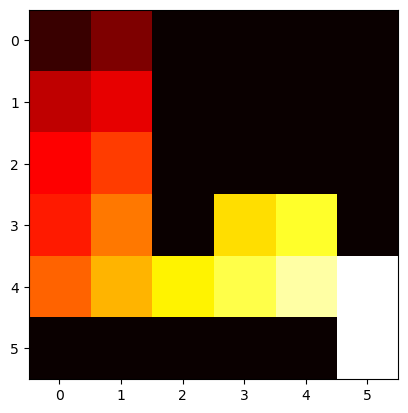

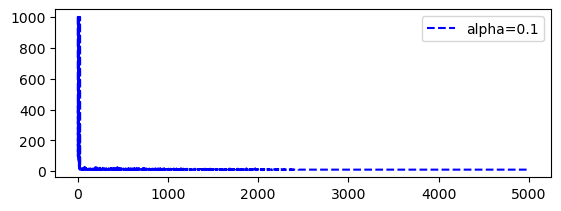

In [18]:
from matplotlib import pyplot as plt

if __name__ == '__main__':
    maze = Maze()
    agent = MazeAgent(maze, random_factor=0.25, alpha=0.1)
    move_history = []
    for i in range(5000):
        while not maze.is_game_over():
            state = maze.get_state()
            action = agent.choose_action(state, maze.allowed_moves())
            maze.update(action)
            state = maze.get_state()
            reward = maze.give_reward()
            agent.update_state_history(state, reward)
            if maze.steps > 1000:
                maze.state = (5,5)
        agent.learn()
        move_history.append(maze.steps)
        maze = Maze()
    print(move_history[-1])
    plt.imshow(mapToArray(agent.G),cmap="hot", vmin=-11, vmax=0,)
    plt.show()
    maze = Maze()
    agent2 = MazeAgent(maze, random_factor=0.25, alpha=0.99)
    move_history2 = []
    #for i in range(5000):
    #    while not maze.is_game_over():
    #        state = maze.get_state()
    #        action = agent2.choose_action(state, maze.allowed_moves())
    #        maze.update(action)
    #        state = maze.get_state()
    #        reward = maze.give_reward()
    #        agent2.update_state_history(state, reward)
    #        if maze.steps > 1000:
    #            maze.state = (5, 5)
    #    agent2.learn()
    #    move_history2.append(maze.steps)
    #    maze = Maze()
    #print(move_history[-1])
    plt.subplot(2,1,1)
    plt.plot(move_history, 'b--')
    plt.legend(['alpha=0.1'])
    #plt.subplot(2,1,2)
    #plt.plot(move_history2)
    #plt.legend(['alpha=0.99'])
    plt.show()
